In [1]:
# Some basic setup:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

from skimage import transform
import torchvision

In [2]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt
from blimpy.utils import rebin
from PIL import Image
from IPython.display import display
import matplotlib.patches as patches

In [3]:
%matplotlib inline

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

fvcore.common.checkpoint INFO     Loading checkpoint from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
fvcore.common.file_io INFO     URL https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl cached in /home/rachelzhong/.torch/fvcore_cache/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl
fvcore.common.checkpoint INFO     Reading a file from 'Detectron2 Model Zoo'


This notebook allows you to run object detection algorithm, or load output from it

In [6]:
index = 10
input_w = 640
input_h = 480
iou_thresh = 0.1
data = np.load("GBT_57803_83207_HIP3876_midfiltered.npy")
sample = data[index,:,:]

## Run the object detection algorithm

In [5]:
def object_detection(sample, input_w, input_h, iou_thresh):
    device = torch.cuda.current_device()
    input = transform.resize(sample, (input_w, input_h)) # upsample
    input_orig = torch.from_numpy(input).float().to(device)
    input = F.normalize(input_orig)
    input = torch.log(input)
    input = cv2.cvtColor(np.float32(input.cpu()),cv2.COLOR_GRAY2RGB) # convert grayscale input to 3 channel
    outputs = predictor(input)
    base_box = outputs['instances'].pred_boxes.tensor
    base_score = outputs['instances'].scores.cpu().numpy()
    base_masks = outputs['instances'].pred_masks.cpu().numpy()
    nms_index = torchvision.ops.nms(torch.tensor(base_box), outputs['instances'].scores, iou_thresh)
    box_nms = []
    scores_nms = []
    masks_nms = []
    for i in nms_index:
        box_nms.append(base_box[i].cpu().numpy())
        scores_nms.append(base_score[i])
        masks_nms.append(base_masks[i])
    output_instance = detectron2.structures.Instances((input_w, input_h))
    output_instance.set("pred_boxes", detectron2.structures.Boxes(box_nms))
    output_instance.set("scores", torch.tensor(scores_nms))
    output_instance.set("pred_masks", torch.tensor(masks_nms))
    return output_instance


In [7]:
outputs = object_detection(sample, input_w, input_h, iou_thresh)

## Load output from object detection

In [9]:
outputs = torch.load("object_detection_GBT_57803_83207_HIP3876_midfiltered.pickle")

In [12]:
sample = data[index,:,:]

## Plots

In [11]:
# These are taken from the SETI energy detection github https://github.com/FX196/SETI-Energy-Detection
MAX_PLT_POINTS      = 65536                  # Max number of points in matplotlib plot
MAX_IMSHOW_POINTS   = (8192, 4096)           # Max number of points in imshow plot

plt_args = {
            'aspect':'auto',
            'origin':'lower',
            'rasterized':True,
            'interpolation':'nearest',
            'cmap':'viridis'
            }
def plot_segment(plot_data):
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = int(plot_data.shape[0] / MAX_IMSHOW_POINTS[0])

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y = int(plot_data.shape[1] / MAX_IMSHOW_POINTS[1])

    print('Downsampling by a factor of (%d, %d)' %(dec_fac_x, dec_fac_y))
    plot_data = rebin(plot_data, dec_fac_x, dec_fac_y)
    plt.figure(figsize=(10, 6))
    plt.imshow(plot_data, **plt_args)

In [13]:
# Modified based on the original plot_segment, plot with detection box
def plot_segment_box(plot_data, boxes):
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = int(plot_data.shape[0] / MAX_IMSHOW_POINTS[0])

    if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y = int(plot_data.shape[1] / MAX_IMSHOW_POINTS[1])
    fig, ax = plt.subplots(1)
    print('Downsampling by a factor of (%d, %d)' %(dec_fac_x, dec_fac_y))
    plot_data = rebin(plot_data, dec_fac_x, dec_fac_y)
    for i in boxes:
        rect = patches.Rectangle(i[0], i[1], i[2],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.figure(figsize=(10, 6))
    ax.imshow(plot_data, **plt_args)

Downsampling by a factor of (1, 1)


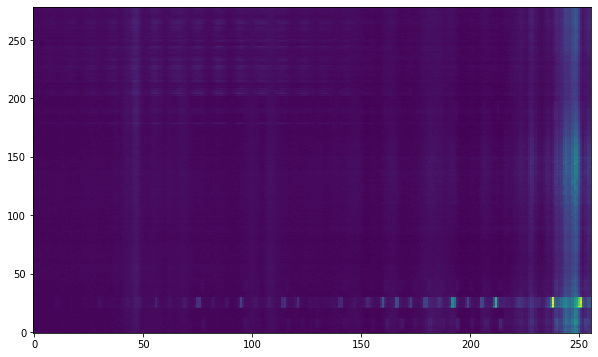

In [14]:
plot_segment(sample)

Downsampling by a factor of (1, 1)


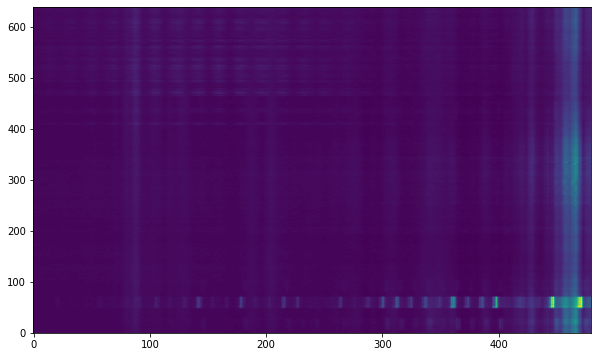

In [15]:
# plot upsampled data
plot_segment(transform.resize(sample, (input_w, input_h)))

In [16]:
pred_box = outputs.pred_boxes.tensor.cpu().numpy()
boxes_plot = []
for i in pred_box:
    boxes_plot.append([(i[0], i[1]), i[2]-i[0], i[3]-i[1]])

Downsampling by a factor of (1, 1)


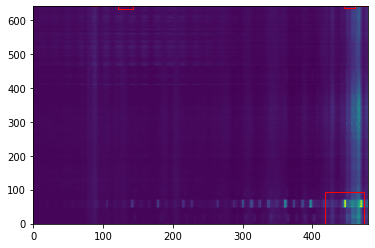

<Figure size 720x432 with 0 Axes>

In [17]:
# Plot upsampled data and detection boxes
plot_segment_box(transform.resize(sample, (input_w, input_h)), boxes_plot)

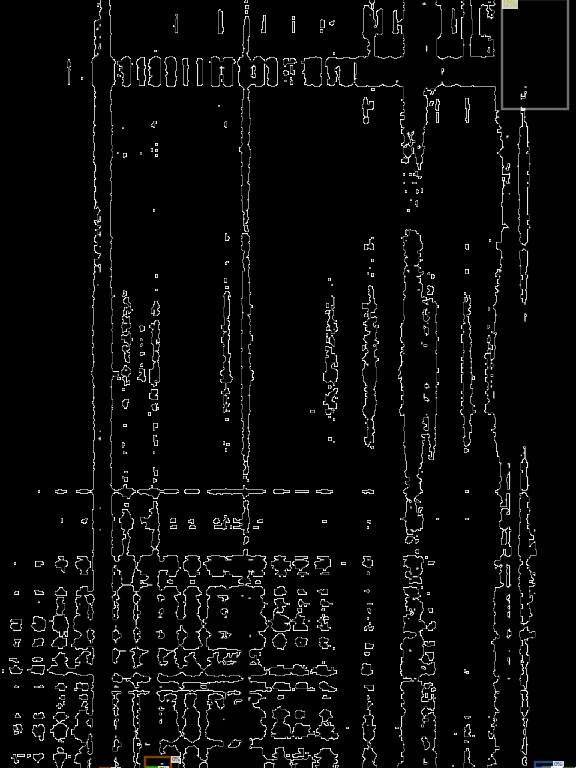

In [18]:
# Use detectron2's `Visualizer` to draw the predictions on the image (note here the images are converted to 3 channel image)
# This image is upside down compared to the ones plotted with plot_segment functions
input_orig = transform.resize(sample, (input_w, input_h)) # upsample
input_orig = cv2.cvtColor(np.float32(input_orig),cv2.COLOR_GRAY2RGB) # convert grayscale input to 3 channel
v = Visualizer(input_orig, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs.to("cpu"))
display(Image.fromarray(((out.get_image()[:, :, ::-1]) * 255).astype(np.uint8)))